# Titanic: Machine Learning from disaster

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3136/logos/front_page.png" alt="Smiley face" height="400" width="400">

#### Descripción de la competencia
El hundimiento del RMS Titanic es uno de los naufragios más infames de la historia.
El 15 de Abril de 1912, el Titanic se hundió luego de colisionar con un iceberg, en donde murieron 1502 de 2224 pasajeros y tripulantes. Esta sensacional tragedia conmocionó a la comunidad internacional y condujo a mejores reglamentos de seguridad para los buques.
Una de las razones por la cual el naufragio causó tal pérdida de vida fue que no había suficiente botes salvavidas para los pasajeros y tripulación. Aunque hubo un elemento de suerte al sobrevivir al hundimiento, algunos grupos de personas tenían mayores probabilidades de sobrevivir que otros, como mujeres y niños, y la clase alta.

En esta competencia queremos que analizar que tipos de personas tenían más posibilidades de sobrevivir. En particular, queremos utilizar técnicas de aprendizaje automático para predecir que pasajeros sobrevivieron a la tragedia. 

**DESCRIPCIÓN DE VARIABLES:**

**survival:** Sobreviviente (0 = No; 1 = Sí)<br/>
**pclass:** Clase social del pasajero (1 = 1ra; 2 = 2da; 3 = 3ra)<br/>
**name:** Nombre<br/>
**sex:** Sexo<br/>
**age:** Edad<br/>
**sibsp:** Número de Hermanos/Esposas a bordo<br/>
**parch:** Número de Padres/Hijos a bordo<br/>
**ticket:** Número de Ticket<br/>
**fare:** Precio del Ticket<br/>
**cabin** Cabina<br/>
**embarked** Puerto de Embarque (C = Cherbourg; Q = Queenstown; S = Southampton)<br/>

**NOTAS ESPECIALES:**<br/>
Pclass is una representación para el estado socio-económico<br/>
 1ra ~ Alta; 2da ~ Media; 3ra ~ Baja

Age está en Años; Fraccionado si Age es menor a uno (1)<br/>
 Si Age está estimada, está en la forma xx.5

Con respecto a las variables relacionadas con la familia (por ej. sibsp y parch) algunas relaciones fueron ignoradas. Las siguientes son definiciones usadas para sibsp y parch.

Hermanos: Hermano, Hermana, Hermanastro, o Hermanastra de pasajero a bordo del Titanic.
Esposo: Marido o Esposa del pasajero a bordo del Titanic
Padres:   Madre o padre del pasajero a bordo del Titanic
Hijos:    Hijo, hija, hijastro o hijastra de pasajero a bordo de Titanic

Otras relaciones excluídas de este estudio incluyen primos, sobrinos/sobrinas, tías/tíos. Algunos niños viajaban solo con una niñera, por lo tanto parch=0 para ellos. También, algunos viajaban con amigos muy cercanos o vecinos, sin embargo, las definiciones no tienen en cuenta esas relaciones.

#### Configuraciones iniciales

In [64]:
options(scipen = 999, repr.plot.width=4, repr.plot.height= 4, warn = -1)

#### Instalación y carga de paquetes necesarios

In [65]:
list.of.packages <- c('ggplot2', 'VIM', 'mice', 'mlbench', 'caret', 'caretEnsemble', 'gbm', 'ipred', 'FSelector',
                     'Matrix')

new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "https://cran.r-project.org")

library(ggplot2)
library(VIM)
library(mice)
library(mlbench)
library(caret)
library(caretEnsemble)
library(gbm)
library(ipred)
library(FSelector)
library(Matrix)

## Comprensión de datos

En una primera instancia debemos cargar y explorar los datos para entender el contexto en donde nos encontramos.

In [66]:
df_train <- read.csv("train.csv", na.string = c('NA', ""))
df_test <- read.csv("test.csv", na.string = c('NA', ""))

train.size <- nrow(df_train)
test.size <- nrow(df_test)

pass.id <- df_test$PassengerId

df_test$Survived <- NA
df_train <- rbind(df_train, df_test)

head(df_train)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


In [67]:
str(df_train)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 929 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 186 levels "A10","A14","A16",..: NA 82 NA 56 NA NA 130 NA NA NA ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


### Verificación de datos faltantes.

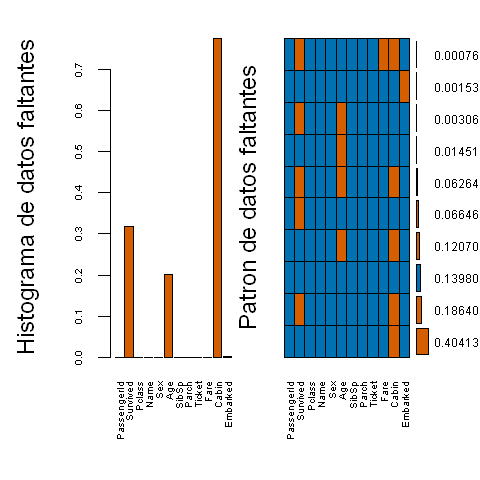

In [68]:
aggr(df_train, digits = 3, numbers = TRUE, labels = names(df_train), cex.axis = .5, cex.numbers = .6,
       gap = 2, ylabs = c("Histograma de datos faltantes", "Patron de datos faltantes"), col = c('#0072B2', '#D55E00'))

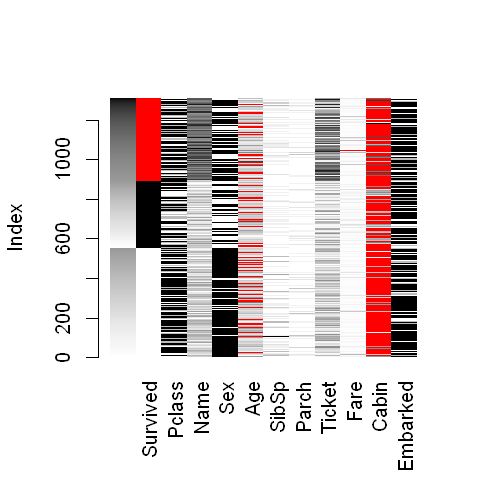

In [69]:
matrixplot(df_train, interactive = F, sortby = "Survived")

Los atributos que más valores faltantes tienen son Cabin y Age. El atributo Survived presenta 50% de datos faltantes porque corresponde al conjunto de prueba y es lo que intentamos predecir.

### Atributo: Survived
Indica si el pasajero sobrevivió o no (Sí = 1; No = 0).

In [70]:
df_train$Survived <- ifelse(df_train$Survived == 0, "No", "Yes")

df_train$Survived <- factor(df_train$Survived)
table(df_train$Survived)
round(prop.table(table(df_train$Survived) * 100), 2)


 No Yes 
549 342 


  No  Yes 
0.62 0.38 

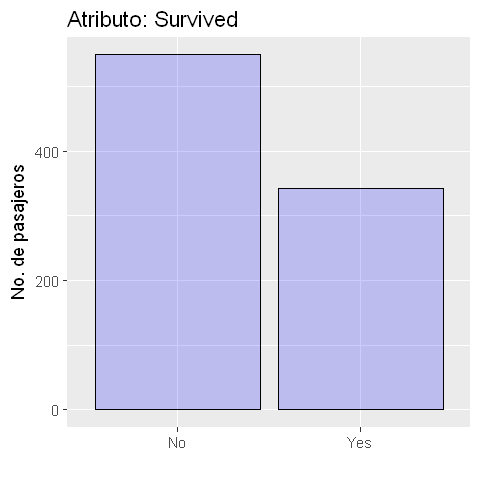

In [71]:
ggplot(data = subset(df_train, !is.na(Survived)), aes(x = Survived)) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Survived') + 
    xlab('') + 
    ylab('No. de pasajeros')

El 62% de los pasajeros sobrevivieron mientras que el 38% no pudieron sobrevivir.

### Atributo: Pclass
Indica la clase social del pasajero: Primera, segunda o tercera clase. (1 = 1st; 2 = 2nd; 3 = 3rd)

In [72]:
df_train$Pclass[df_train$Pclass == 1] <- "1st"
df_train$Pclass[df_train$Pclass == 2] <- "2nd"
df_train$Pclass[df_train$Pclass == 3] <- "3rd"

df_train$Pclass <- factor(df_train$Pclass)

table(df_train$Pclass)
round(prop.table(table(df_train$Pclass) * 100), 2)


1st 2nd 3rd 
323 277 709 


 1st  2nd  3rd 
0.25 0.21 0.54 

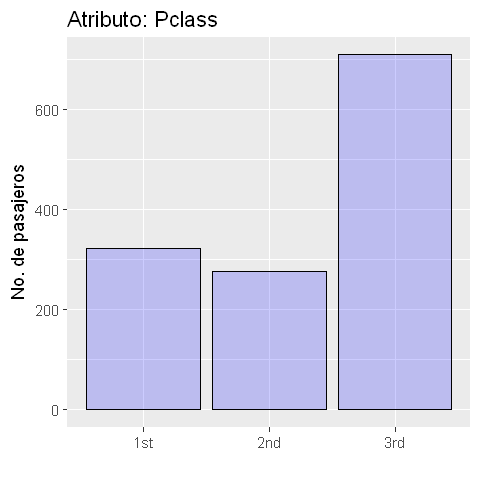

In [73]:
ggplot(data = df_train, aes(x = as.factor(Pclass))) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Pclass') + 
    xlab('') + 
    ylab('No. de pasajeros')

El 55% de los pasajeros correspondían a la tercera clase. Esto es el doble de las primera o la segunda clase.

### Atributo: Name
Nombre del pasajero.
Los nombres están compuestos de la siguiente forma: Apellido, TituloHonorífico. Nombre
Lo que haremos es extraer el Título como una columna aparte.

In [74]:
head(df_train$Name)

[1] Braund, Mr. Owen Harris                            
[2] Cumings, Mrs. John Bradley (Florence Briggs Thayer)
[3] Heikkinen, Miss. Laina                             
[4] Futrelle, Mrs. Jacques Heath (Lily May Peel)       
[5] Allen, Mr. William Henry                           
[6] Moran, Mr. James                                   
1307 Levels: Abbing, Mr. Anthony ... Zakarian, Mr. Ortin

Como podemos observar cada nombre tiene un título honorífico asociado, esto nos puede servir para más adelante construir un nuevo atributo.

### Atributo: Sex
Género del pasajero: Male (hombre) o Female (mujer) 

In [75]:
table(df_train$Sex)
round(prop.table(table(df_train$Sex))*100,2)

table(is.na(df_train$Sex))


female   male 
   466    843 


female   male 
  35.6   64.4 


FALSE 
 1309 

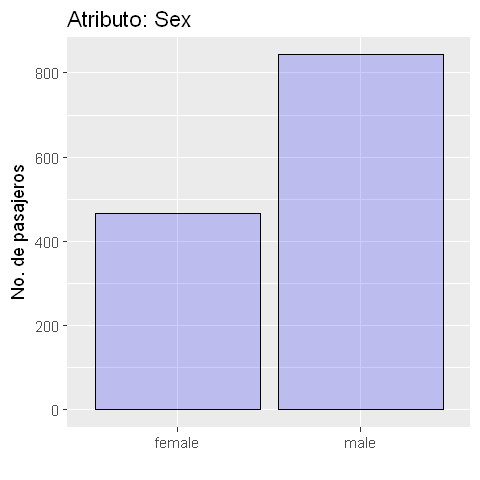

In [76]:
ggplot(data = df_train, aes(x = as.factor(Sex))) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Sex') + 
    xlab('') + 
    ylab('No. de pasajeros')

El 65% de los pasajeros son hombres.

### Atributo: Age
Edad del pasajero.

In [77]:
summary(df_train$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.17   21.00   28.00   29.88   39.00   80.00     263 

La edad promedio de los pasajeros es de 30 años mientras que la mediana es de 28 años. La edad máxima es de 80 años.
No se tiene la edad de 263 pasajeros.

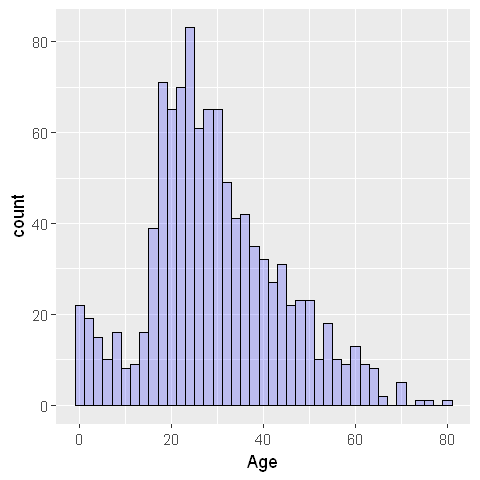

In [78]:
ggplot(data = df_train, aes(x = Age)) + geom_histogram(binwidth = 2, col="black", fill="blue", alpha = .2)

La mayor parte de los pasajeros tienen entre 20 y 40 años. Como vimos la mediana es de 28 años.

#### Imputación: Age

Para aquellos que no tienen las edades cargadas lo reemplazaremos con valores aleatorios entre el primer y tercer cuartil.

In [79]:
na_count <- sum(is.na(df_train$Age))
set.seed(123)

ages <- round(runif(na_count, summary(df_train$Age)[2], summary(df_train$Age)[5]), 2)
head(ages)

[1] 26.18 35.19 28.36 36.89 37.93 21.82

In [80]:
df_train$Age[which(is.na(df_train$Age))] <- ages

Una vez que imputamos los datos volvemos a graficar.

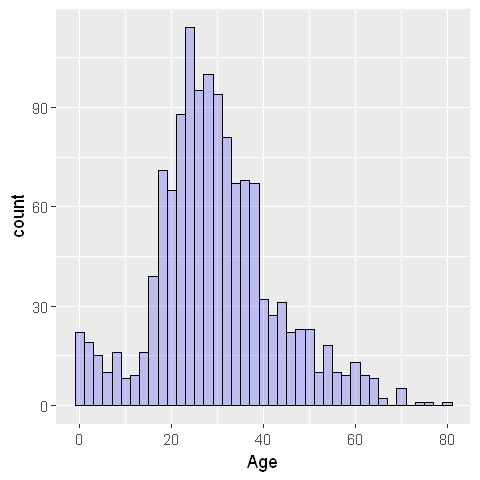

In [81]:
ggplot(data = df_train, aes(x = Age)) + geom_histogram(binwidth = 2, col="black", fill="blue", alpha = .2)

Como vemos mantenemos el histograma bastante similiar antes de la imputación.

### Atributo: SibSp
Número de hermanos/matrimonio a bordo por pasajero.

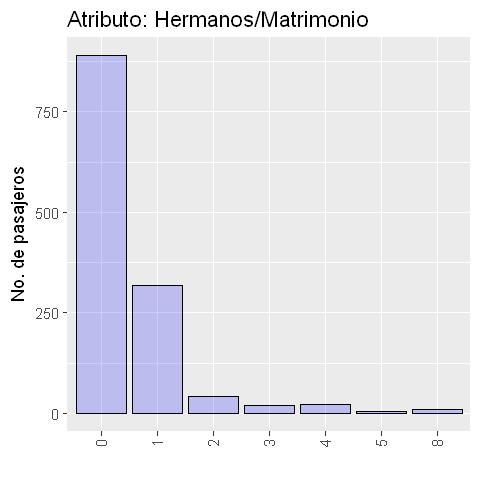

In [82]:
df_train$SibSp <- factor(df_train$SibSp, levels = sort(unique(df_train$SibSp)), labels = sort(unique(df_train$SibSp)))

ggplot(data = df_train, aes(x = as.factor(SibSp))) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Hermanos/Matrimonio') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))

In [83]:
table(df_train$SibSp)
round(prop.table(table(df_train$SibSp)) * 100, 2)


  0   1   2   3   4   5   8 
891 319  42  20  22   6   9 


    0     1     2     3     4     5     8 
68.07 24.37  3.21  1.53  1.68  0.46  0.69 

### Atributo: parch
Número de padres/hijos a bordo.

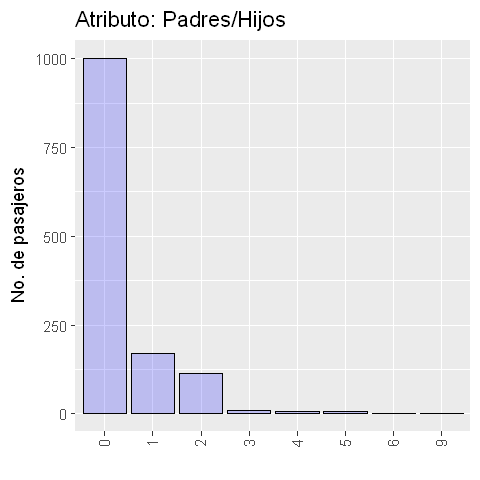

In [84]:
df_train$Parch<- factor(df_train$Parch, levels = sort(unique(df_train$Parch)), labels = sort(unique(df_train$Parch)))

ggplot(data = df_train, aes(x = as.factor(Parch))) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Padres/Hijos') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))

In [85]:
table(df_train$Parch)
round(prop.table(table(df_train$Parch)) * 100, 2)


   0    1    2    3    4    5    6    9 
1002  170  113    8    6    6    2    2 


    0     1     2     3     4     5     6     9 
76.55 12.99  8.63  0.61  0.46  0.46  0.15  0.15 

El 75% de los pasajeros no tenían padres o hijos a bordo.

### Atributo: Ticket
Número del ticket.

In [86]:
df_train$Ticket <- as.integer(df_train$Ticket)

### Atributo: Fare
Es la tarifa que pagó el pasajero.

In [87]:
summary(df_train$Fare)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   7.896  14.450  33.300  31.280 512.300       1 

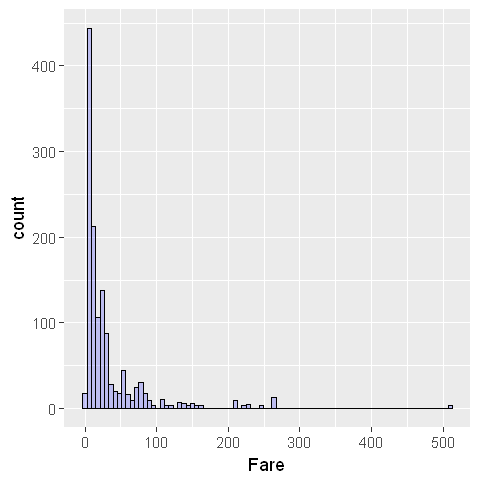

In [88]:
ggplot(data = df_train, aes(x = Fare)) + geom_histogram(binwidth = 6, col="black", fill="blue", alpha = .2)

El promedio del precio de un ticket es de \$33, mientras que lo máximo que se pagó por uno fue más de \$500 (Quizás viajaban en grupo). Podemos ver que hay tickets con valor \$0, podríamos atribuir estos tickes a niños o bebés pero si exploramos bien los datos estos tickets corresponden a adultos. Hay un valor faltante que también lo reemplazaremos con la media.

In [89]:
df_train[df_train$Fare == 0,]
df_train[is.na(df_train$Fare),]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
180,180,No,3rd,"Leonard, Mr. Lionel",male,36.00,0,0,575,0,NA,S
264,264,No,1st,"Harrison, Mr. William",male,40.00,0,0,17,0,B94,S
272,272,Yes,3rd,"Tornquist, Mr. William Henry",male,25.00,0,0,575,0,NA,S
278,278,No,2nd,"Parkes, Mr. Francis ""Frank""",male,31.10,0,0,136,0,NA,S
303,303,No,3rd,"Johnson, Mr. William Cahoone Jr",male,19.00,0,0,575,0,NA,S
414,414,No,2nd,"Cunningham, Mr. Alfred Fleming",male,33.03,0,0,136,0,NA,S
467,467,No,2nd,"Campbell, Mr. William",male,32.82,0,0,136,0,NA,S
482,482,No,2nd,"Frost, Mr. Anthony Wood ""Archie""",male,22.68,0,0,137,0,NA,S
598,598,No,3rd,"Johnson, Mr. Alfred",male,49.00,0,0,575,0,NA,S
634,634,No,1st,"Parr, Mr. William Henry Marsh",male,33.11,0,0,14,0,NA,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1044,1044,NA,3rd,"Storey, Mr. Thomas",male,60.5,0,0,855,NA,NA,S


Reemplazemos estos valores con la mediana.

In [90]:
df_train$Fare[which(df_train$Fare == 0)] <- median(df_train$Fare, na.rm = TRUE)
df_train$Fare[which(is.na(df_train$Fare))] <- median(df_train$Fare, na.rm = TRUE)
df_train$Fare[which(df_train$Fare > 300)] <- median(df_train$Fare, na.rm = TRUE)

Ahora vemos que el mínimo es \$3.17. Volvemos a graficar el histograma.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.171   7.925  14.450  31.950  31.000 263.000 

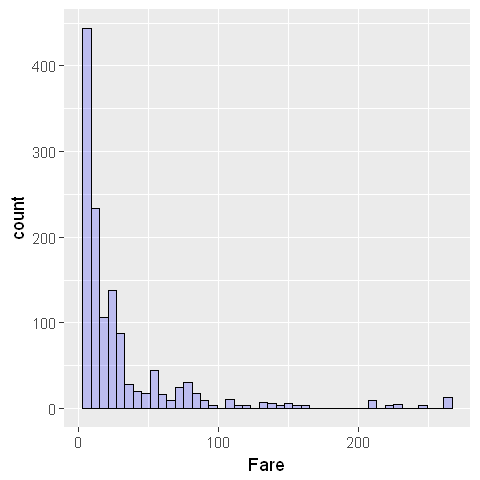

In [91]:
summary(df_train$Fare)
ggplot(data = df_train, aes(x = Fare)) + geom_histogram(binwidth = 6, col="black", fill="blue", alpha = .2)

### Atributo: Cabin
Cabina.

In [92]:
str(df_train$Cabin)
head(df_train$Cabin)

table(is.na(df_train$Cabin))
round(prop.table(table(is.na(df_train$Cabin)) * 100),2)

 Factor w/ 186 levels "A10","A14","A16",..: NA 82 NA 56 NA NA 130 NA NA NA ...


[1] <NA> C85  <NA> C123 <NA> <NA>
186 Levels: A10 A14 A16 A19 A20 A23 A24 A26 A31 A32 A34 A36 A5 A6 A7 ... F E57


FALSE  TRUE 
  295  1014 


FALSE  TRUE 
 0.23  0.77 

#### Imputación: Cabin

No vamos a imputar estos datos porque falta el 75%.

### Atributo: Embarked
Embarque. (C = Cherbourg; Q = Queenstown; S = Southampton)

In [93]:
str(df_train$Embarked)

df_train$Embarked[df_train$Embarked == ""] <- NA

table(df_train$Embarked)
round(prop.table(table(df_train$Embarked)) *100, 2)

table(is.na(df_train$Embarked))

 Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...



  C   Q   S 
270 123 914 


    C     Q     S 
20.66  9.41 69.93 


FALSE  TRUE 
 1307     2 

#### Imputación: Embarked

Hay dos pasajeros que no tienen una Embarque asignado. Así que les asignaremos el valor más común que es S.

In [94]:
idx <- which(is.na(df_train$Embarked))
df_train$Embarked[idx] <- "S"
df_train$Embarked <- factor(df_train$Embarked)

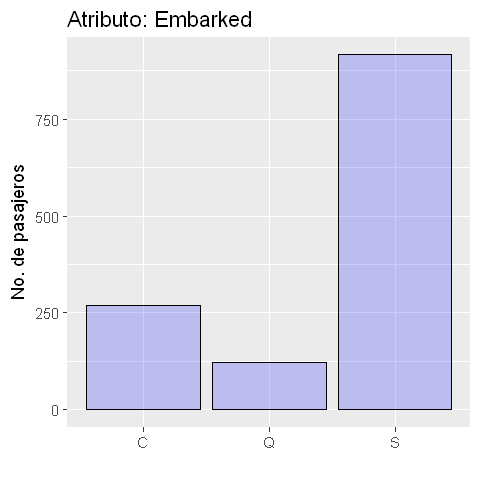

In [95]:
ggplot(data = df_train, aes(x = Embarked)) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Embarked') + 
    xlab('') + 
    ylab('No. de pasajeros')

El 70% de los pasajeros partieron del mismo puerto.

***  
### Construcción de nuevos atributos
A partir de los atributos que ya tenemos construiremos nuevos atributos que nos pueden sumar poder predictivo a nuestro modelo.

### Atributo: Title
Vamos a extraer el título honorífico de cada pasajero/tripulante y utilizarlo como un nuevo atributo.

In [96]:
df_train$Title <- gsub("(.*, )|(\\..*)", "", df_train$Name)
unique(df_train$Title)
length(unique(df_train$Title))
table(df_train$Title)

df_train$Title <- as.factor(df_train$Title)

[1] "Mr"           "Mrs"          "Miss"         "Master"       "Don"         
 [6] "Rev"          "Dr"           "Mme"          "Ms"           "Major"       
[11] "Lady"         "Sir"          "Mlle"         "Col"          "Capt"        
[16] "the Countess" "Jonkheer"     "Dona"

[1] 18


        Capt          Col          Don         Dona           Dr     Jonkheer 
           1            4            1            1            8            1 
        Lady        Major       Master         Miss         Mlle          Mme 
           1            2           61          260            2            1 
          Mr          Mrs           Ms          Rev          Sir the Countess 
         757          197            2            8            1            1 

Tenemos 18 titulos honoríficos diferentes. La mayor parte corresponde a Mr. Mrs. y Miss. Hay varios titulos un tanto inusuales así que podríamos convertirlos a los titulos más comunes. Mme (Madame) y Mlle (Mademoiselle) son bastantes similares así que podríamos tomar como uno solo.
Para los hombres tenemos titulos menos usuales como: Captain, Don, Major y Sir.
Para las mujeres tenemos, Dona, Lady, Johnkeer and the Countess.

In [97]:
df_train$Title[df_train$Title %in% c('Mme', 'Mlle')] <- 'Mlle'
df_train$Title[df_train$Title %in% c('Capt', 'Don', 'Major', 'Sir')] <- 'Sir'
df_train$Title[df_train$Title %in% c('Dona', 'Lady', 'the Countess', 'Jonkheer')] <- 'Lady'

df_train$Title <- factor(df_train$Title)

table(df_train$Title)


   Col     Dr   Lady Master   Miss   Mlle     Mr    Mrs     Ms    Rev    Sir 
     4      8      4     61    260      3    757    197      2      8      5 

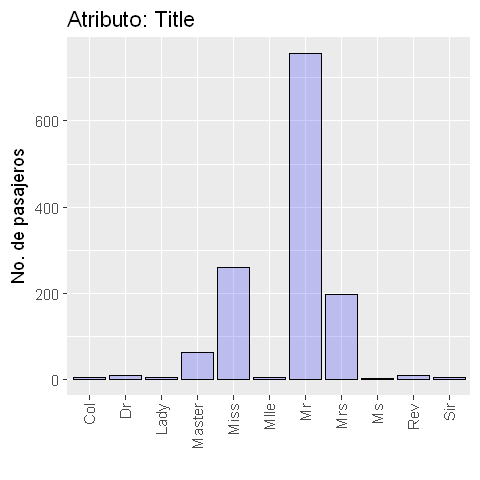

In [98]:
ggplot(data = df_train, aes(x = Title)) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Title') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))

### Atributo: AgeD (Discretización de la edad)
A partir de la edad vamos a obtener rangos de cada uno. Esto nos puede dar una mejor visión de la política: Niños y mujeres primero, con respecto a la prioridad en los botes salvavidas.

Ahora discreticemos el atributo Age de la siguiente forma:
1. Niño: entre 0 y 18 años
2. Adulto: entre 18 y 50 años
4. Anciano: mayor a 50 años

In [99]:
df_train$AgeD[df_train$Age >= 0] <- "Child"
df_train$AgeD[df_train$Age > 18] <- "Adult"
df_train$AgeD[df_train$Age >= 50] <- "Elderly"

df_train$AgeD <- factor(df_train$AgeD)

table(df_train$AgeD)
round(prop.table(table(df_train$AgeD)) * 100,2)



  Adult   Child Elderly 
   1006     193     110 


  Adult   Child Elderly 
  76.85   14.74    8.40 

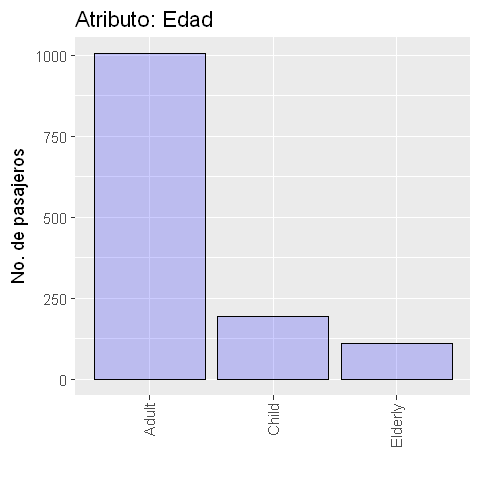

In [100]:
ggplot(data = df_train, aes(x = AgeD)) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Edad') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))   

3/4 de los pasajeros/tripulantes eran adultos.

### Atributo: Family
A partir de los atributos SibSp y Parch podemos estimar el tamaño de la familia del pasajero.

In [101]:
df_train$Family <- as.integer(df_train$SibSp) + as.integer(df_train$Parch) + 1
df_train$Family <- factor(df_train$Family)

table(df_train$Family)
round(prop.table(table(df_train$Family)) * 100, 2)


  3   4   5   6   7   8   9  10  11 
790 235 159  43  22  25  16   8  11 


    3     4     5     6     7     8     9    10    11 
60.35 17.95 12.15  3.28  1.68  1.91  1.22  0.61  0.84 

Como vemos tenemos familia a partir de 3 hasta 11. Discretizaremos en rangos estos valores.

In [102]:
df_train$FamilySize <- NULL
df_train$Family <- as.integer(df_train$Family)

df_train$FamilySize[df_train$Family > 0] <- "Small"
df_train$FamilySize[df_train$Family >= 4] <- "Medium"
df_train$FamilySize[df_train$Family > 8] <- "Large"

df_train$FamilySize <- factor(df_train$FamilySize)

table(df_train$FamilySize)


 Large Medium  Small 
    11    114   1184 

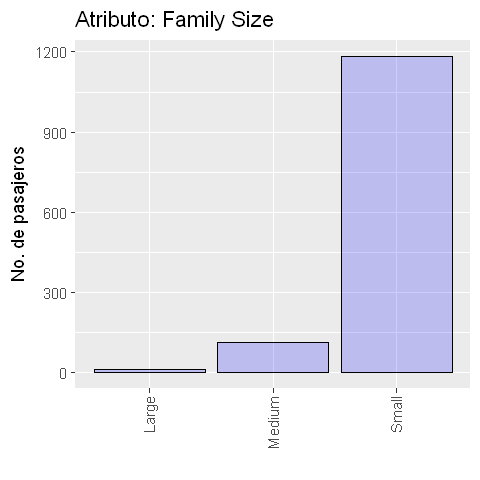

In [103]:
ggplot(data = df_train, aes(x = FamilySize)) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Family Size') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))

### Atributo: Deck
La cabina de cada pasajero está compuesto por una letra que corresponde a la cubierta seguido del número de cabina. Ahora vamos a extraer la cubierta del atributo cabina porque quizás sea un buen predictor.
Hay pasajeros que tienen asignados tres cabinas por ej. C23 C25 C27, pero la cubierta se mantiene consistente así que de todas formas vamos a extraer el primer caracter.

In [104]:
head(df_train$Cabin[!is.na(df_train$Cabin)], 10)

[1] C85         C123        E46         G6          C103        D56        
 [7] A6          C23 C25 C27 B78         D33        
186 Levels: A10 A14 A16 A19 A20 A23 A24 A26 A31 A32 A34 A36 A5 A6 A7 ... F E57

In [105]:
df_train$Deck <- substring(df_train$Cabin, 1, 1)
df_train$Deck <- factor(df_train$Deck)

table(df_train$Deck)


 A  B  C  D  E  F  G  T 
22 65 94 46 41 21  5  1 

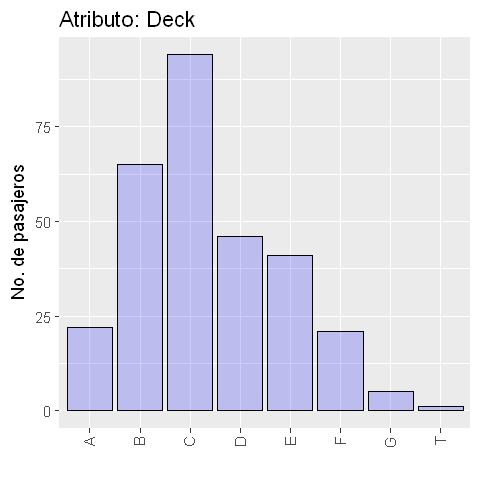

In [106]:
ggplot(data = subset(df_train, !is.na(Deck)), aes(x = Deck)) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Deck') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))

### Atributo: WomanOrChild
Construiremos un atributo que indica si el pasajero era mujer o niño, es decir, tenía prioridad con respecto a los botes salvavidas.

In [107]:
df_train$WomanOrChild <- ifelse(df_train$Sex == 'female' | df_train$AgeD == "Child", "Yes", "No")

df_train$WomanOrChild <- factor(df_train$WomanOrChild)

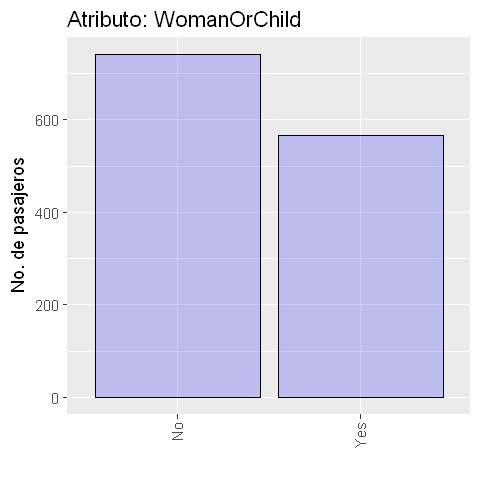

In [108]:
ggplot(df_train, aes(x = WomanOrChild)) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: WomanOrChild') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))

*** 

### Análisis multivariado

Ahora veremos como se relacionan las variables entre sí para encontrar correlaciones.

In [109]:
str(df_train)

'data.frame':	1309 obs. of  18 variables:
 $ PassengerId : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived    : Factor w/ 2 levels "No","Yes": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass      : Factor w/ 3 levels "1st","2nd","3rd": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name        : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex         : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age         : num  22 38 26 35 35 ...
 $ SibSp       : Factor w/ 7 levels "0","1","2","3",..: 2 2 1 2 1 1 1 4 1 2 ...
 $ Parch       : Factor w/ 8 levels "0","1","2","3",..: 1 1 1 1 1 1 1 2 3 1 ...
 $ Ticket      : int  524 597 670 50 473 276 86 396 345 133 ...
 $ Fare        : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin       : Factor w/ 186 levels "A10","A14","A16",..: NA 82 NA 56 NA NA 130 NA NA NA ...
 $ Embarked    : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title       : Factor w/ 11 levels "Col","Dr","Lady",..: 7 8 5 8 7 7 7 4 8 8 ...
 $ AgeD

### Atributos: Pclass vs. AgeD

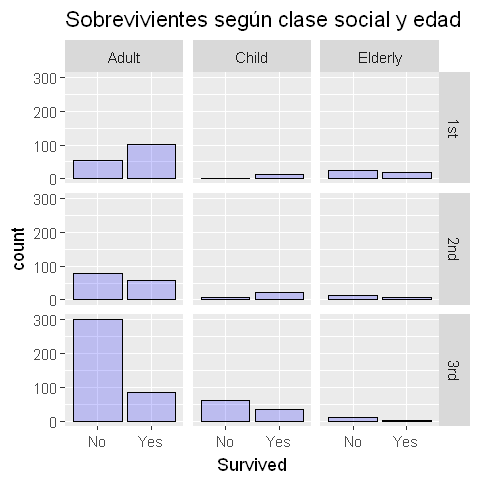

In [110]:
ggplot(data = subset(df_train, !is.na(Survived)), aes(Survived, ..count..)) + 
    geom_bar(col="black", fill="blue", alpha = .2, position = "dodge") +
    ggtitle("Sobrevivientes según clase social y edad") +
    facet_grid(Pclass ~ AgeD)

    Podemos ver que los que tuvieron menos suerte son los adultos pertenecientes a la tercera clase.
    Los niños que pertenecían a la primera clase fueron más afortunados que los demás.

### Atributos: Pclass vs. Sex

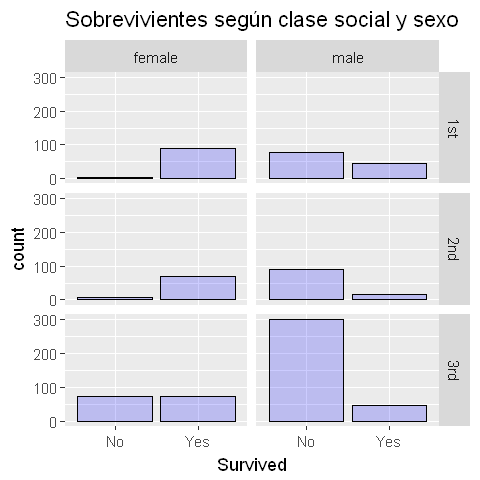

In [111]:
ggplot(data = subset(df_train, !is.na(Survived)), aes(Survived, ..count..)) + 
    geom_bar(col="black", fill="blue", alpha = .2, position = "dodge") +
    ggtitle("Sobrevivientes según clase social y sexo") +
    facet_grid(Pclass ~ Sex)

    Es mucho mayor la proporción de mujeres que sobrevivieron en todas las clases, esto es debido a la prioridad que tenían las mujeres para subirse a los botes salvavidas.
    Las mujeres de tercera clase tuvieron fueron menos afortunadas.
    En la segunda clase sobrevivieron muy pocos hombres.

### Atributos: AgeD vs. Sex

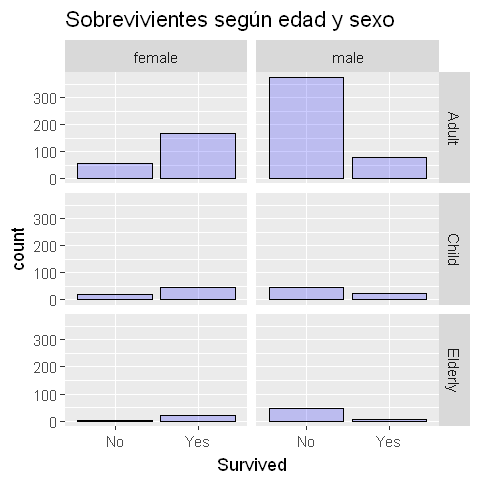

In [112]:
ggplot(data = subset(df_train, !is.na(Survived)), aes(Survived, ..count..)) + 
    geom_bar(col="black", fill="blue", alpha = .2, position = "dodge") +
    ggtitle("Sobrevivientes según edad y sexo") +
    facet_grid(AgeD ~ Sex)

    Según la política de prioridad de mujeres y niños la columna "female" y la fila "Child" por el lado del "No" deberían ser más bajas que las del "Yes". No así cumpliendose para los niños donde la mayor parte no pudo sobrevivir.
    Los ancianos tenían menos chances de sobrevivir siendo hombres.

### Atributos: Pclass vs FamilySize

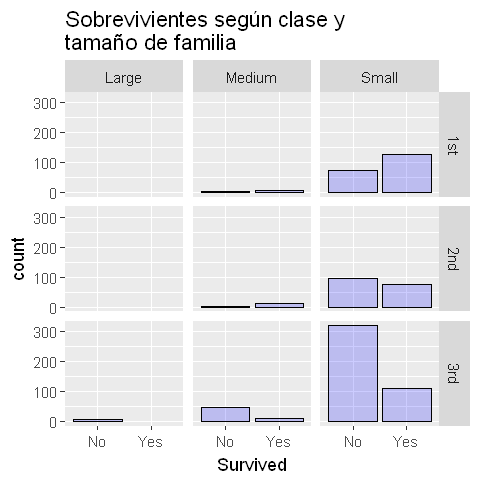

In [113]:
ggplot(data = subset(df_train, !is.na(Survived)), aes(Survived, ..count..)) + 
    geom_bar(col="black", fill="blue", alpha = .2, position = "dodge") +
    ggtitle("Sobrevivientes según clase y\ntamaño de familia") +
    facet_grid(Pclass ~ FamilySize)

    En la tercera clase las familias más pequeñas tuvieron menos suerte. En cambio, en la segunda clase las familias medianas tuvieron mas chances de sobrevivir.

### Atributos: Pclass vs Deck

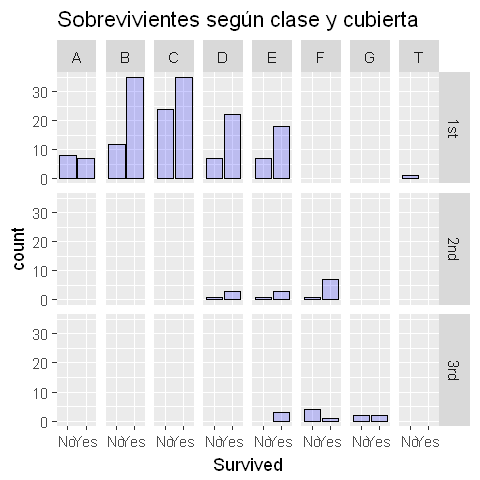

In [114]:
df_temp <- subset(df_train, !is.na(Deck))
ggplot(data = subset(df_temp, !is.na(Survived)), aes(Survived, ..count..)) + 
    geom_bar(col="black", fill="blue", alpha = .2, position = "dodge") +
    ggtitle("Sobrevivientes según clase y cubierta") +
    facet_grid(Pclass ~ Deck)

### Atributos: Pclass vs. Embarked

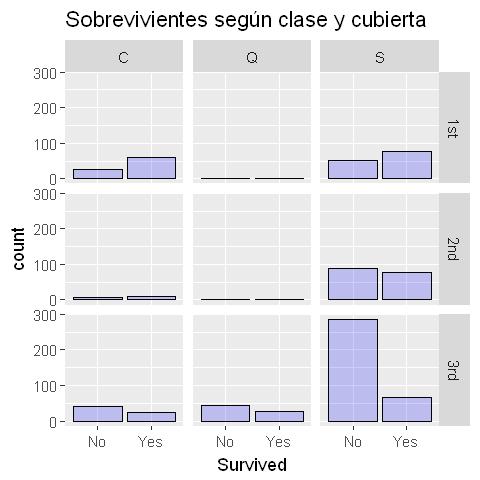

In [115]:
ggplot(data = subset(df_train, !is.na(Survived)), aes(Survived, ..count..)) + 
    geom_bar(col="black", fill="blue", alpha = .2, position = "dodge") +
    ggtitle("Sobrevivientes según clase y cubierta") +
    facet_grid(Pclass ~ Embarked)

    En Cherbourg embarcaron más gente de primera clase. En cambio, en Southampton la amplia mayoría pertenecía a tercera clase.

### Atributos: Pclass vs. Title

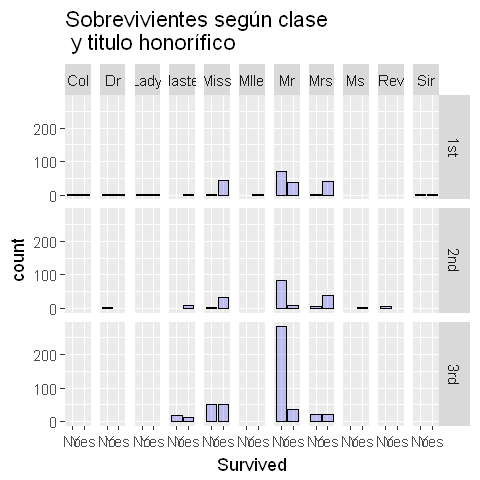

In [116]:
ggplot(data = subset(df_train, !is.na(Survived)), aes(Survived, ..count..)) + 
    geom_bar(col="black", fill="blue", alpha = .2, position = "dodge") +
    ggtitle("Sobrevivientes según clase\n y titulo honorífico") +
    facet_grid(Pclass ~ Title)

### Atributos: Survived vs. Fare

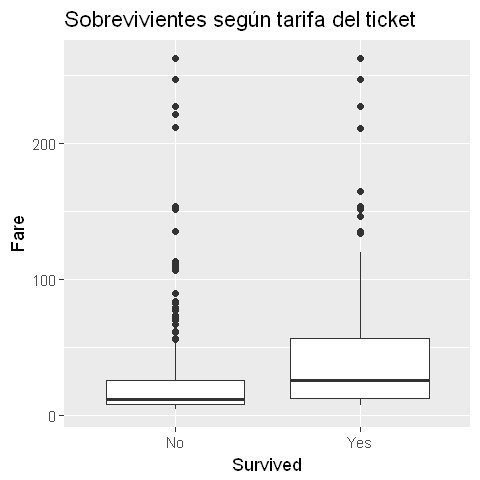

In [117]:
ggplot(data = subset(df_train, !is.na(Survived)), aes(x= Survived, y = Fare)) + 
    geom_boxplot() +
    ggtitle("Sobrevivientes según tarifa del ticket")

### Atributos: Pclass vs. Fare

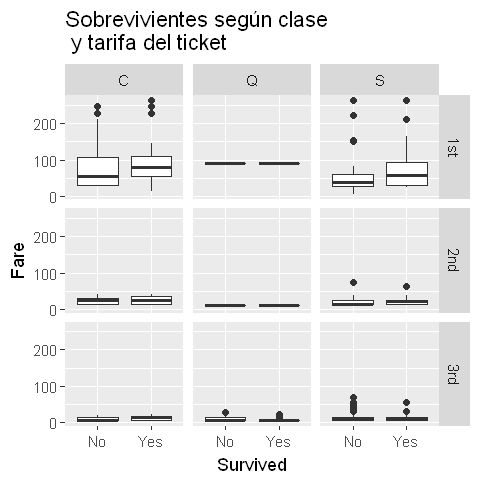

In [118]:
ggplot(data = subset(df_train, !is.na(Survived)), aes(x= Survived, y = Fare)) + 
    geom_boxplot() +
    ggtitle("Sobrevivientes según clase\n y tarifa del ticket") +
    facet_grid(Pclass ~ Embarked)

    Los tickets más caros eran los de primera clases obviamente, en especial de los que embarcaron en Cherbourg y Southampton.

### Atributos: Embarked vs FamilySize

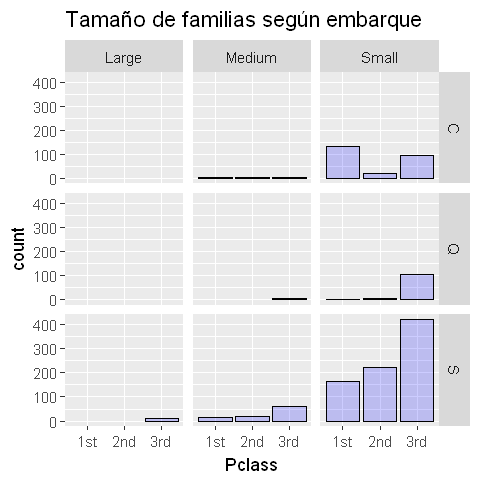

In [119]:
ggplot(data = df_train, aes(Pclass, ..count..)) + 
    geom_bar(col="black", fill="blue", alpha = .2, position = "dodge") +
    ggtitle("Tamaño de familias según embarque") +
    facet_grid(Embarked ~ FamilySize)

### Atributos: Pclass vs WomanOrChild

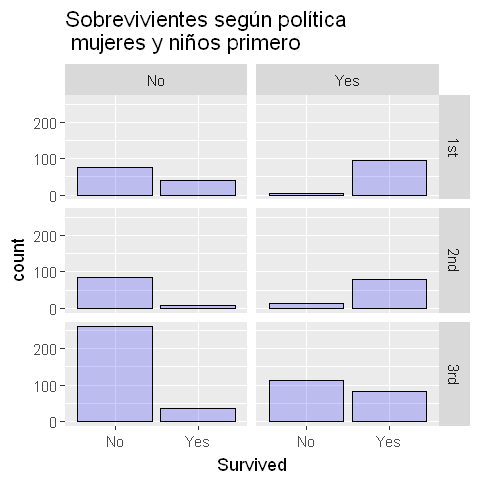

In [120]:
ggplot(data = subset(df_train, !is.na(Survived)), aes(Survived, ..count..)) + 
    geom_bar(col="black", fill="blue", alpha = .2, position = "dodge") +
    ggtitle("Sobrevivientes según política\n mujeres y niños primero") +
    facet_grid(Pclass ~ WomanOrChild)

    La prioridad de "mujeres y niños primero" se cumple para la primera y segunda clase, no así para la tercera clase donde la mayoría de las mujeres o niños no sobrevivieron.
    De igual forma la mayoría de los pasajeros que no eran mujeres o niños no sobrevivieron al hundimiento.

*** 
## Preparación de datos

#### Importancia de atributos

In [121]:
#Attribute importance
res <- gain.ratio(Survived ~ ., data = df.train)
res

ERROR: Error in is.data.frame(data): objeto 'df.train' no encontrado


In [ ]:
str(df_train)

In [ ]:
dataset <- df_train[, c('Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'Title', 
                         'AgeD', 'WomanOrChild', 'FamilySize')]
str(dataset)

In [ ]:
df <- dataset[1:train.size, ]

trainIndex <- createDataPartition(df$Survived, p = .8, list = FALSE, times = 1)
df.train <- df[ trainIndex,]
df.test  <- df[-trainIndex,]

y <- df.test$Survived
df.test$Survived <- NULL

str(df.train)
str(df.test)

In [ ]:
matrixplot(df.train, interactive = F, sortby = "Survived")

*** 
## Modelado

### Boosting algorithms
Consiste en construir modelos (tipicamente del mismo tipo) en donde cada uno aprende a arreglar los errores de predicción a partir de un modelo anterior en la cadena.

En primer lugar utilizaremos los algoritmos con boosting: C5.0 y Stochastic Gradient Boosting (gbm)

In [ ]:
#Inicializamos algunos parámetros
control <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
seed <- 7
metric <- "Accuracy"

# C5.0
set.seed(seed)
fit.c50 <- train(Survived~., data=df.train, method="C5.0", metric=metric, trControl=control)

# Stochastic Gradient Boosting
set.seed(seed)
fit.gbm <- train(Survived~., data=df.train, method="gbm", metric=metric, trControl=control, verbose=FALSE)

# Resumen de resultados
boosting_results <- resamples(list(c5.0=fit.c50, gbm=fit.gbm))
summary(boosting_results)
dotplot(boosting_results)

#### Resultados en el test set

In [ ]:
predictions <- predict(fit.c50, df.test)
mean(predictions == y)

predictions <- predict(fit.gbm, df.test)
mean(predictions == y)

### Bagging algorithms
Consiste en construir multiples modelos (tipicamente del mismo tipo) a partir de diferentes submuestras del conjunto de entrenamiento.

Los algoritmos de bagging que vamos a utilizar son: Bagged CART y el popular Random Forest

In [ ]:
## Inicializamos algunos parámetros
control <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
seed <- 7
metric <- "Accuracy"

# Bagged CART
set.seed(seed)
fit.treebag <- train(Survived~., data=df.train, method="treebag", metric=metric, trControl=control)

# Random Forest
set.seed(seed)
fit.rf <- train(Survived~., data=df.train, method="rf", metric=metric, trControl=control)

# Resumen de resultados
bagging_results <- resamples(list(treebag=fit.treebag, rf=fit.rf))
summary(bagging_results)
dotplot(bagging_results)

##### Resultados en el test set

In [ ]:
predictions <- predict(fit.treebag, df.test)
mean(predictions == y)

predictions <- predict(fit.rf, df.test)
mean(predictions == y)

### Stacking algorithms
Consiste en construir multiples modelos (tipicamente de **distintos** tipos) y un modelo supervisor que aprende a combinar de la mejor forma las predicciones de los modelos primarios.

Creamos 5 submodelos:
1. Linear Discriminate Analysis (LDA)
2. Classification and Regression Trees (CART)
3. Logistic Regression (via Generalized Linear Model or GLM)
4. k-Nearest Neighbors (kNN)
5. Support Vector Machine with a Radial Basis Kernel Function (SVM)
6. Generalized Boosted Regression Model (GBM)

In [ ]:
# Creamos los submodelos

control <- trainControl(method="repeatedcv", number=10, repeats=3, savePredictions=TRUE, classProbs=TRUE)
algorithmList <- c('rpart', 'knn', 'treebag')
set.seed(seed)
models <- caretList(Survived ~ ., data=df.train, trControl=control, methodList=algorithmList)
results <- resamples(models)
summary(results)
dotplot(results)

Cuando combinamos las predicciones de diferentes modelos usando stacking, es deseable que las predicciones hechas por los submodelos tengan baja correlación. Esto nos sugiere que los modelos son hábiles pero en maneras diferentes, y permiten a un nuevo clasificador averiguar como obtener lo mejor de cada modelo para mejorar la puntuación.

Si las predicciones de los submodelos están altamente correlacionadas (> 0.75) entonces realizarian las mismas predicciones (o muy similares) la mayoría de las veces reduciendo así los beneficios de combinar las predicciones.

In [ ]:
# Correlaciones entre modelos
modelCor(results)
splom(results)

### Predicciones en test set

In [ ]:
ll <- lapply(models, function(x) {
    
    predictions <- predict(x, df.test)
    cat(x[['method']], ":", round(mean(y == predictions)*100,2), '%\n')
    })

invisible(ll)

#### Stacking usando glm

In [ ]:
stackControl <- trainControl(method="repeatedcv", number=10, repeats=3, savePredictions=TRUE, classProbs=TRUE)
set.seed(seed)
stack.glm <- caretStack(models, method="glm", metric="Accuracy", trControl=stackControl)
print(stack.glm)

In [ ]:
predictions <- predict(stack.glm, df.test)
mean(y == predictions)

#### Stacking usando gbm

In [ ]:
stackControl <- trainControl(method="repeatedcv", number=10, repeats=3, savePredictions=TRUE, classProbs=TRUE)
set.seed(seed)
stack.gbm <- caretStack(models, method="gbm", metric="Accuracy", trControl=stackControl)
print(stack.gbm)

In [ ]:
predictions <- predict(stack.gbm, df.test)
mean(predictions == y)

### Conclusiones
Los mejores puntajes en el leaderboar se obtuvieron con gbm simple.

In [ ]:
fit.gbm

*** 
## Submit

In [ ]:
test.csv <- dataset[pass.id,]
test.csv$Survived <- NULL

predictions <- predict(fit.gbm, test.csv)

predictions <- ifelse(predictions == "Yes", 1, 0)

submit <- data.frame(PassengerId = passId, Survived = predictions)
write.csv(submit, file = "submit.csv", row.names = FALSE, quote = FALSE)